### Init

In [3]:
import requests
import re

### Submitter

In [2]:
import psycopg2
psycopg2_conn = psycopg2.connect(dbname='public_contracts', user='postgres', password='admin', host='localhost', port='5432')

In [20]:
import psycopg2
opendata_conn = psycopg2.connect(dbname='public_contracts_v2', user='postgres', password='Profinit1', host='193.85.191.172', port='5432')

In [1]:
import psycopg2
from utils.database import *

class EntityManager(DBManager):
    
    def __init__(self, connection):
        super().__init__(connection)
        self._load_query = """
        select e.entity_id, e.dic, e.ico, e.name, e.address, e.latitude, e.longitude,
        array_agg(es.description) as items from entity e left join entity_subject es on e.entity_id=es.entity_id
        group by e.entity_id"""
        self._load_items_query = 'select * from entity_subject'

    def load_from_DB(self, parts=10):
        print("Running query: " + self._load_query)
        raw_data = self.runQuery(self._load_query)
        
        entities = {}
        total_entities = len(raw_data)
        print("Loading total " + str(total_entities) + " entities")
        for i, ent in enumerate(raw_data):
            if i % (int(total_entities / parts)+1) == 0:
                print("Progress: {}%".format(numpy.ceil(i * 100 / total_entities)))
            entity_id = ent[0]
            dic = ent[1]
            ico = ent[2]
            name = ent[3]
            address = ent[4]
            gps_coords = (ent[5], ent[6])
            items = ent[7]
            entity = entities.get(entity_id, {'dic':dic, 'ico':ico, 'name':name, 'address': address, 'gps': gps_coords, 'items':[]})
            entities[entity_id] = entity
        print("Done")
        return pandas.DataFrame.from_dict(entities, orient='index')

    
    def truncate_DB(self):
        self.runQuery('truncate table entity_subject')

    def save_to_DB(self, df_entities):
        for index, row in df_entities.iterrows():
            entity_id = index
            address = row['address']
            gps_coords = row['gps']
            latitude, longitude = (gps_coords[0], gps_coords[1]) if gps_coords else (None, None)
            items = row['items']
            to_print = [str(x)[:5] if x is not None else '-   ' \
                        for x in [entity_id, address, latitude, longitude, len(items) if isinstance(items, set) else 0]]
            print("Updating entity {} with address {}, gps:({},{}), #items:{}".format(*to_print))
            cursor = self._connection.cursor()
            postgres_update_query = """UPDATE entity
                                        SET address=%s, latitude=%s, longitude=%s
                                        WHERE entity_id=%s"""
            record_to_insert = (address, latitude, longitude, entity_id)
            cursor.execute(postgres_update_query, record_to_insert)

            self._connection.commit()
            cursor.close()
            
            if not items:
                continue
            for i, item in enumerate(items):
                cursor = self._connection.cursor()
                postgres_insert_query = """INSERT INTO entity_subject (entity_id, description)
                                            VALUES (%s,%s)"""
                record_to_insert = (entity_id, item)
                cursor.execute(postgres_insert_query, record_to_insert)

                self._connection.commit()
                count = cursor.rowcount
                cursor.close()

In [ ]:
entmngr = EntityManager(psycopg2_conn)
entmngr

In [46]:
df_entity

,dic,ico,name,address,gps,items
184,None,,"BOHEMIA CAR, s.r.o.",None,"(None, None)",[]
87,None,14504456,VIALIT SOBĚSLAV spol. s r. o.,"Soběslav,Soběslav II,,Na Švadlačkách,478,39201","(49.2361211172, 14.7217741617)",[]
477,None,61944122,"OLZA, spol. s r.o.","Jablunkov,Jablunkov,,Žihla,931,73991","(49.5657384791, 18.7770821431)",[]
273,None,25857631,"SKARAB, s.r.o.","Příbor,Příbor,,9. května,1162,74258","(49.6449704682, 18.1531999454)",[]
51,None,29113563,VERNAT s.r.o.,"Karlovy Vary,Tašovice,,Sopečná,58,36018","(50.2137402489, 12.8098705036)",[]
...,...,...,...,...,...,...
465,None,00254592,Město Hroznětín,"Hroznětín,Hroznětín,,Krušnohorské náměstí,1,36233","(50.3094065245, 12.8729646313)",[]
449,None,28447085,Konstrukce a dopravní stavby s.r.o.,"Zbraslavice,Zbraslavice,,,2,28521","(49.812374665, 15.1815341565)",[]
64,None,60071346,Reno Šumava a.s.,"Vlachovo Březí,Vlachovo Březí,,Pražská,326,38422","(49.0866259539, 13.9641239959)",[]
55,None,45804371,"INSTALACE Praha, spol. s r.o.","Praha,Nové Město,Praha 1,Truhlářská,1108,11000","(50.0896240543, 14.4285942679)",[]


In [13]:
df_entity = entmngr.loadFromDB()
df_entity

Running query: 
        select e.entity_id, e.dic, e.ico, e.name, e.address, e.latitude, e.longitude,
        array_agg(es.description) as items from entity e left join entity_subject es on e.entity_id=es.entity_id
        group by e.entity_id
Loading total 485 entities
Progress: 0.0%
Progress: 11.0%
Progress: 21.0%
Progress: 31.0%
Progress: 41.0%
Progress: 51.0%
Progress: 61.0%
Progress: 71.0%
Progress: 81.0%
Progress: 91.0%


,dic,ico,name,address,gps,items
184,None,,"BOHEMIA CAR, s.r.o.",None,"(None, None)",[]
87,None,14504456,VIALIT SOBĚSLAV spol. s r. o.,"Soběslav,Soběslav II,,Na Švadlačkách,478,39201","(49.2361211172, 14.7217741617)",[]
477,None,61944122,"OLZA, spol. s r.o.","Jablunkov,Jablunkov,,Žihla,931,73991","(49.5657384791, 18.7770821431)",[]
273,None,25857631,"SKARAB, s.r.o.","Příbor,Příbor,,9. května,1162,74258","(49.6449704682, 18.1531999454)",[]
51,None,29113563,VERNAT s.r.o.,"Karlovy Vary,Tašovice,,Sopečná,58,36018","(50.2137402489, 12.8098705036)",[]
...,...,...,...,...,...,...
465,None,00254592,Město Hroznětín,"Hroznětín,Hroznětín,,Krušnohorské náměstí,1,36233","(50.3094065245, 12.8729646313)",[]
449,None,28447085,Konstrukce a dopravní stavby s.r.o.,"Zbraslavice,Zbraslavice,,,2,28521","(49.812374665, 15.1815341565)",[]
64,None,60071346,Reno Šumava a.s.,"Vlachovo Březí,Vlachovo Březí,,Pražská,326,38422","(49.0866259539, 13.9641239959)",[]
55,None,45804371,"INSTALACE Praha, spol. s r.o.","Praha,Nové Město,Praha 1,Truhlářská,1108,11000","(50.0896240543, 14.4285942679)",[]


### Ares

In [2]:
from xml.etree import cElementTree as ElementTree

class XmlListConfig(list):
    def __init__(self, aList):
        for element in aList:
            if element:
                # treat like dict
                if len(element) == 1 or element[0].tag != element[1].tag:
                    self.append(XmlDictConfig(element))
                # treat like list
                elif element[0].tag == element[1].tag:
                    self.append(XmlListConfig(element))
            elif element.text:
                text = element.text.strip()
                if text:
                    self.append(text)


class XmlDictConfig(dict):
    '''
    Example usage:

    >>> tree = ElementTree.parse('your_file.xml')
    >>> root = tree.getroot()
    >>> xmldict = XmlDictConfig(root)

    Or, if you want to use an XML string:

    >>> root = ElementTree.XML(xml_string)
    >>> xmldict = XmlDictConfig(root)

    And then use xmldict for what it is... a dict.
    '''
    def __init__(self, parent_element):
        if parent_element.items():
            self.update(dict(parent_element.items()))
        for element in parent_element:
            if element:
                # treat like dict - we assume that if the first two tags
                # in a series are different, then they are all different.
                if len(element) == 1 or element[0].tag != element[1].tag:
                    aDict = XmlDictConfig(element)
                # treat like list - we assume that if the first two tags
                # in a series are the same, then the rest are the same.
                else:
                    # here, we put the list in dictionary; the key is the
                    # tag name the list elements all share in common, and
                    # the value is the list itself 
                    aDict = {element[0].tag: XmlListConfig(element)}
                # if the tag has attributes, add those to the dict
                if element.items():
                    aDict.update(dict(element.items()))
                self.update({element.tag: aDict})
            # this assumes that if you've got an attribute in a tag,
            # you won't be having any text. This may or may not be a 
            # good idea -- time will tell. It works for the way we are
            # currently doing XML configuration files...
            elif element.items():
                self.update({element.tag: dict(element.items())})
            # finally, if there are no child tags and no attributes, extract
            # the text
            else:
                self.update({element.tag: element.text})

In [3]:
class XMLParser:
    
    def __init__(self, xml_string):
        transformed_content = re.sub(r'xmlns:([^=]+)="[^"]*"', r'xmlns:\1="\1"', xml_string)
        root = ElementTree.XML(transformed_content)
        xmldict = XmlDictConfig(root)
        self._xml_dict = xmldict

class ARESParser(XMLParser):
    
    def _check_structure(self, hierarchy=[], node=None):
        if node is None:
            node = self._xml_dict
        for next_node in hierarchy:
            node = node.get(next_node, None)
            if not node:
                return False
        return True
    
    def getAddress(self):
        if not self._check_structure(['{are}Odpoved','{D}VBAS','{D}AA']):
            return None
        adrdict = self._xml_dict['{are}Odpoved']['{D}VBAS']['{D}AA']
        address_fields = ['{D}N', '{D}NCO', '{D}NMC', '{D}NU', '{D}CD','{D}PSC']
        address = ','.join([adrdict.get(field, '') for field in address_fields])
        return address
    
    def getSubject(self):
        if not self._check_structure(['{are}Odpoved','{D}VBAS','{D}PPI', '{D}PP']):
            return None
        subj_items = []
        items = self._xml_dict['{are}Odpoved']['{D}VBAS']['{D}PPI']['{D}PP']
        if isinstance(items, dict) and self._check_structure(['{D}T'], items):
            items = items['{D}T']
        if isinstance(items, str):
            subj_items.append(items)
        else:
            for item in items:
                if isinstance(item, dict) and self._check_structure(['{D}T'], item):
                    item = item['{D}T']
                if isinstance(item, list):
                    subj_items.extend(item)
                else:
                    subj_items.append(item)
        return set(subj_items)

In [30]:
response = requests.get('http://wwwinfo.mfcr.cz/cgi-bin/ares/darv_bas.cgi?ico=&active=false')
response

<Response [200]>

In [33]:
transformed_content = re.sub(r'xmlns:([^=]+)="[^"]*"', r'xmlns:\1="\1"', response.content.decode('utf-8'))
root = ElementTree.XML(transformed_content)
xmldict = XmlDictConfig(root)
dpp = xmldict['{are}Odpoved']
dpp

{'{D}PID': '0',
 '{D}E': {'{D}EK': '1', '{D}ET': '\nChyba 31 - bez parametru\n'},
 '{D}VH': {'{D}K': '2'},
 '{D}PZA': '0',
 '{D}UVOD': {'{D}ND': 'Výpis z dat Registru ARES - aktuální stav ke dni 1899-12-31',
  '{D}ADB': '1899-12-31',
  '{D}DVY': '2020-04-20',
  '{D}CAS': '00:12:07',
  '{D}Typ_odkazu': '0'}}

In [281]:
isinstance(dpp, list)

True

In [34]:
parser = ARESParser(response.content.decode('utf-8'))
address = parser.getAddress()
print(address)
items = parser.getSubject()
print(items)

None
None


### Mapy

In [12]:
import re

class MapyParser(XMLParser):
    
    def __init__(self, xml_string):
        self._xml = xml_string
        self._xpattern = re.compile(r'x="([\d]+\.[\d]*)"')
        self._ypattern = re.compile(r'y="([\d]+\.[\d]*)"')
    
    def getGPS(self):
        if 'item' in self._xml:
            x = self._xpattern.search(self._xml).group(1)
            y = self._ypattern.search(self._xml).group(1)
            return y,x
        return None

In [141]:
response = requests.get('https://api.mapy.cz/geocode?query=Brno,Černovice,Brno-Černovice,Olomoucká,1273,61800')
response


<Response [200]>

In [142]:
mparser = MapyParser(response.content.decode('utf-8'))
gpspoint = mparser.getGPS()
gpspoint

('50.5999042304', '15.51457122')

### Enrich

In [20]:
import requests

class EntityEnricher:
    
    def __init__(self,
                 connection=None,
                 ares_url="http://wwwinfo.mfcr.cz/cgi-bin/ares/darv_bas.cgi?ico={}&active=false",
                 mapy_url="https://api.mapy.cz/geocode?query={}"):
        self._ares_url = ares_url
        self._mapy_url = mapy_url
        self._entity_manager = EntityManager(connection)
        
    def load_from_db(self):
        return self._entity_manager.load_from_DB()
        
    def save_to_db(self, df):
        self._entity_manager.save_to_DB(df)
        
    def enrich_dataframe(self, df):
        for i, (index, row) in enumerate(df.iterrows()):
            ico = str(row['ico'])
            print("{}: Getting ico {}".format(str(i), ico))
            areresponse = requests.get(self._ares_url.format(ico))
            if areresponse.status_code != 200:
                print('Error with ico:'+ico)
                continue
            parser = ARESParser(areresponse.content.decode('utf-8'))
            address = parser.getAddress()
            items = parser.getSubject()
            df.loc[index, 'items'] = items

            if address is None:
                continue
            print('    Getting GPS for address {}'.format(address))
            mapyresponse = requests.get(self._mapy_url.format(address))
            if mapyresponse.status_code  != 200:
                print('Error with address:'+address)
                continue
            mparser = MapyParser(mapyresponse.content.decode('utf-8'))
            gpspoint = mparser.getGPS()
            df.loc[index, 'address'] = address
            df.loc[index, 'gps'] = gpspoint
        return df
    
    def split_dataframe_to_batches(self, df=None, batch_size=100):
        i = 0
        batches = []
        while i<len(df.index):
            batches.append(df[i:i+batch_size])
            i+=batch_size
        return batches
    
    def batch_process_enrichment(self, df=None, batch_size=100):
        if df is None:
            df = self.load_from_db()
        df_batches = self.split_dataframe_to_batches(df, batch_size)
        print("Processing {} batches of total {}".format(len(df_batches),len(df.index)))
        for i, df_batch in enumerate(df_batches):
            print("Processing batch {}/{}".format(i, len(df_batches)))
            self.enrich_dataframe(df_batch)
            self.save_to_db(df_batch)

In [54]:
%%time

df_enriched = enrich_dataframe(df_opendata_slice)
df_enriched

0 00006947
    Praha,Malá Strana,Praha 1,Letenská,525,11800
1 00025429
    Praha,Nové Město,Praha 2,Vyšehradská,427,12800
2 00024341
    Praha,Nové Město,Praha 2,Palackého náměstí,375,12800
3 00164801
    Praha,Vršovice,Praha 10,Vršovická,1442,10000
4 00023671
    Praha,Malá Strana,Praha 1,Maltézské náměstí,471,11800
5 66002222
    Praha,Staré Město,Praha 1,Staroměstské náměstí,932,11000
6 70856788
    Praha,Vinohrady,Praha 2,Vinohradská,1896,12000
7 04095316
    Praha,Strašnice,Praha 3,U nákladového nádraží,3144,13000
8 00007064
    Praha,Holešovice,Praha 7,Nad štolou,936,17000
9 47609109
    Praha,Staré Město,Praha 1,Na Františku,1039,11000
10 60162694
    Praha,Hradčany,Praha 6,Tychonova,221,16000
11 66003008
    Praha,Nové Město,Praha 1,nábřeží Ludvíka Svobody,1222,11000
12 70856508
    Praha,Libeň,Praha 9,Sokolovská,1955,19000
13 15028909  
    Vysoké Mýto,Vysoké Mýto-Město,,Vladislavova,29,56601
14 00303844
    Choryně,Choryně,,,200,75642
15 28333187
    Brno,Brno-město,Brno-stře

143 25842234
    Zlaté Hory,Zlaté Hory,,Nádražní,281,79376
144 26833433
    Lipník nad Bečvou,Lipník nad Bečvou I-Město,,Svat. Čecha,1562,75131
145 25584553
    Brno,Staré Brno,Brno-střed,Úvoz,977,60200
146 49450301
    Praha,Nové Město,Praha 1,Purkyňova,2121,11000
147 25751069
    Praha,Vinoř,Praha-Vinoř,Lohenická,607,19017
148 18627226
    Modletice,Modletice,,Lipová,72,25101
149 45194629
    Olomouc,Holice,,Stará Přerovská,765,77900
150 41692519
    Čestlice,Čestlice,,Obchodní,131,25101
151 25900218
    Moravany,Moravany,,Bohunická cesta,727,66448
152 26045095
    Humpolec,Humpolec,,Vosmíkova,900,39601
153 15032108
    Chrudim,Chrudim IV,,Průmyslová,23,53701
154 26824256
    Ostrava,Polanka nad Odrou,Polanka nad Odrou,K Vydralinám,705,72525
155 60850671
    Pelhřimov,Pelhřimov,,K Silu,1426,39301
156 63906821
    Předslavice,Předslavice,,,19,38701
157 62508831
    Jindřichův Hradec,Jindřichův Hradec II,,Jarošovská,1267,37701
158 28722833
    Roudnice nad Labem,Roudnice nad Labem,,Šve

281 25342100
    Brno,Štýřice,Brno-střed,Pražákova,1000,61900
282 27713130
    Otnice,Otnice,,Dědina,447,68354
283 44051379
    Brodek u Prostějova,Sněhotice,,,1,79807
284 02319438
    Trnov,Záhornice,,,78,51732
285 43005560
    Praha,Strašnice,Praha 10,Dubečská,3238,10000
286 25598643
    Buchlovice,Buchlovice,,Hradišťská,573,68708
287 02189330
    Ostrava,Moravská Ostrava,Moravská Ostrava a Přívoz,Sokolská třída,1615,70200
288 27713342
    Luleč,Luleč,,,419,68303
289 25349023
    Brno,Staré Brno,Brno-střed,Nové sady,988,60200
290 25317628
    Brno,Trnitá,Brno-střed,Mlýnská,388,60200
291 26035782
    Praha,Nusle,Praha 4,Hvězdova,1716,14000
292 25836625
    Vidče,Vidče,,,28,75653
293 00014915
    Praha,Libeň,Praha 8,Koželužská,2450,18000
294 26402068
    Otovice,Otovice,,Na Vlečce,177,36001
295 00080837
    Dubí,Pozorka,,Ruská,260,41703
296 49197339
    Plzeň,Východní Předměstí,Plzeň 4,Chrástecká,2601,30100
297 28667271
    Klášterec nad Ohří,Miřetice u Klášterce nad Ohří,,V Zátiší,835

427 26304775
    Otrokovice,Otrokovice,,Objízdná,1898,76502
428 11314044
    Milevsko,Milevsko,,Petrovická,440,39901
429 25522001
    Čejkovice,Čejkovice,,Na Padělkách,308,69615
430 47536161
    Praha,Smíchov,Praha 5,náměstí 14. října,1307,15000
431 25507770
    Moravské Budějovice,Moravské Budějovice,,Dopravní,127,67602
432 45797439
    Praha,Holešovice,Praha 7,U topíren,860,17000
433 48152528
434 28066839
    Vrábče,Vrábče,,Ves-Na Návsi,261,37001
435 63217139
    Pardubice,Zelené Předměstí,Pardubice V,Nemošická,1495,53002
436 35683066
437 45476021
    Šlapanice,Šlapanice,,Čechova,797,66451
438 28307453
    Prostějov,Prostějov,,Janáčkova,4642,79601
439 25385551
    Olomouc,Hodolany,,tř. Kosmonautů,989,77900
440 46504621
    Chrudim,Chrudim IV,,Tovární,1130,53701
441 42340802
    Zlín,Příluky,,,386,76001
442 60722291
    Prostějov,Prostějov,,Ječmínkova,1981,79601
443 63486270
    Prostějov,Prostějov,,Brněnská,4498,79601
444 26856026
    Olomouc,Nová Ulice,,Legionářská,1319,77900
445 00

    Liberec,Liberec IV-Perštýn,Liberec (nečleněné město),Šumavská,532,46001
566 01934317
    Plzeň,Koterov,Plzeň 2-Slovany,Koterovská,590,32600
567 26353342
    Sokolov,Sokolov,,Vítězná,2201,35601
568 26381001
    Dalovice,Dalovice,,Hlavní,74,36263
569 45144613
    Rakovník,Rakovník II,,S. K. Neumanna,2229,26901
570 25285271
    Moravská Třebová,Předměstí,,Josefská,385,57101
571 40525929
    Praha,Braník,Praha 4,Zelený pruh,1560,14000
572 42660351
    Brno,Komárov,Brno-jih,Komárovské nábřeží,465,61700
573 25542141
    Moravské Budějovice,Moravské Budějovice,,Jaroměřická,1120,67602
574 25267027
    Černožice,Černožice,,Na Štěpníku,32,50304
575 25101790
    Praha,Holešovice,Praha 7,V háji,1092,17000
576 49761901
    Karlovy Vary,Dvory,,Starorolská,137,36006
577 26224216
    Branišovice,Branišovice,,,59,67177
578 71587047
    Praha,Braník,Praha 4,Mezivrší,1447,14700
579 28045360
    Karlovy Vary,Stará Role,,M. Rovenské,992,36017
580 28738152
    Ústí nad Labem,Ústí nad Labem-centrum,Ústí 

    Říčany,Říčany,,Barákova,237,25101
702 28512090
    Teplice,Trnovany,,Emilie Dvořákové,843,41501
703 60733098
    Brno,Štýřice,Brno-střed,Renneská třída,787,63900
704 46347534
    Brno,Lesná,Brno-sever,Okružní,828,63800
705 60697318
    Brno,Černovice,Brno-Černovice,Bolzanova,763,61800
706 28306651
    Brno,Brněnské Ivanovice,Brno-Tuřany,Jahodová,526,62000
707 25538748
    Brno,Černá Pole,Brno-střed,Lidická,2030,60200
708 00220159
    Brno,Trnitá,Brno-střed,Zvonařka,408,61700
709 46347542
    Brno,Řečkovice,Brno-Řečkovice a Mokrá Hora,Maříkova,1899,62100
710 18565832
    Brno,Komárov,Brno-jih,Sokolova,714,61700
711 00346292
    Brno,Bohunice,Brno-Bohunice,Kamenice,798,62500
712 24201596
    Praha,Vokovice,Praha 6,Lužná,591,16000
713 03157164
    Brno,Slatina,,Tuřanka,1222,62700
714 45192731
    Ostrava,Poruba,Poruba,K Myslivně,2140,70800
715 11123273
    Pardubice,Studánka,Pardubice III,Jana Zajíce,637,53012
716 25623290
    Praha,Vršovice,Praha 10,28. pluku,458,10100
717 25833812
 

840 28593634
    Ostrava,Mariánské Hory,Mariánské Hory a Hulváky,Chemická,2039,70900
841 60748516
    Třebíč,Nové Dvory,,Samešova,1144,67401
842 28596854
    Bruntál,Bruntál,,U Stadionu,1999,79201
843 28597192
    Ostrava,Vítkovice,Vítkovice,Obránců míru,863,70300
844 00360210
    Děčín,Děčín IV-Podmokly,,Čsl. mládeže,1,40502
845 00360392
    Částkov,Částkov,,,86,68712
846 28597508
    Karviná,Ráj,,U Lesa,869,73401
847 00360571
    Chomutov,Chomutov,,Palackého,86,43001
848 60749105
    Žďár nad Sázavou,Žďár nad Sázavou 3,,Okružní,1889,59101
849 28597575
    Praha,Staré Město,Praha 1,Na příkopě,393,11000
850 28598547
    Litovel,Litovel,,Šmakalova,206,78401
851 60749679
    Dukovany,Dukovany,,,220,67556
852 28993144
    Praha,Žižkov,Praha 3,Kubelíkova,1224,13000
853 22768670
    Praha,Chodov,Praha 11,Babická,2329,14900
854 65999533
    Praha,Nové Město,Praha 1,Žitná,608,11000
855 69057842
    Praha,Staré Město,Praha 1,Staroměstské náměstí,4,11000
856 27864367
    Praha,Podolí,Praha 4,Na

979 05884969
    Praha,Dejvice,Praha 6,Evropská,693,16000
980 25638955
    Praha,Vinohrady,Praha 2,Španělská,1073,12000
981 46678468
    Praha,Smíchov,Praha 5,Plzeňská,3217,15000
982 26949890
    Ostrava,Heřmanice,Slezská Ostrava,Orlovská,726,71300
983 27708853
    Třinec,Lyžbice,,nám. Svobody,527,73961
984 26295059
    Kunovice,Kunovice,,V Pastouškách,205,68604
985 26750066
    Praha,Břevnov,Praha 6,Bělohorská,264,16900
986 44851804
    Praha,Zličín,Praha-Zličín,Na Radosti,184,15521
987 45146802
    Kladno,Kladno,,Vašíčkova,3081,27204
988 25041738
    Ústí nad Labem,Ústí nad Labem-centrum,Ústí nad Labem-město,Velká hradební,3122,40001
989 28169522
    Kolín,Kolín III,,U Nemocnice,430,28002
990 45809712
    Praha,Ďáblice,Praha-Ďáblice,Ďáblická,791,18200
991 64361357
    Cheb,Cheb,,Karlova,2472,35002
992 28902378
    Praha,Záběhlice,Praha 10,Jesenická,265,10600
993 48117820
    Praha,Michle,Praha 4,Jihlavská,1558,14000
994 28614291
    Nový Hrozenkov,Nový Hrozenkov,,,832,75604
995 25904

,dic,ico,name,address,gps,items
1,CZ00006947,00006947,Ministerstvo financí ČR,"Praha,Malá Strana,Praha 1,Letenská,525,11800","(50.089144925, 14.4071893631)",None
2,None,00025429,Ministerstvo spravedlnosti ČR,"Praha,Nové Město,Praha 2,Vyšehradská,427,12800","(50.0698507608, 14.4188255775)",None
3,None,00024341,Ministerstvo zdravotnictví,"Praha,Nové Město,Praha 2,Palackého náměstí,375...","(50.0730336844, 14.4153630777)",None
4,None,00164801,Ministerstvo životního prostředí,"Praha,Vršovice,Praha 10,Vršovická,1442,10000","(50.0694598393, 14.4678937408)",None
5,CZ00023671,00023671,Ministerstvo kultury ČR,"Praha,Malá Strana,Praha 1,Maltézské náměstí,47...","(50.0854605529, 14.4058268572)",None
...,...,...,...,...,...,...
996,None,25904540,"amethyst.cz, s.r.o.","Ostrava,Koblov,Slezská Ostrava,Lámař,41,71100","(49.8740648538, 18.2792723754)","{Výroba, instalace, opravy elektrických strojů..."
997,None,27399508,XERTEC a.s.,"Praha,Braník,Praha 4,Údolní,212,14700","(50.0297317737, 14.4093586125)","{výroba, obchod a služby neuvedené v přílohách..."
998,None,00560235,"K.o.T.a.S, spol. s r.o.","Třinec,Kanada,,Míru,26,73961","(49.6769597401, 18.6485914804)","{Výroba, instalace, opravy elektrických strojů..."
999,None,61251844,"""5P"", s.r.o.","Praha,Vršovice,Praha 10,Ruská,707,10100","(50.0725976016, 14.4616957815)","{Výroba, instalace, opravy elektrických strojů..."


In [58]:
df_enriched[df_enriched.gps.isna()]

,dic,ico,name,address,gps,items
381,None,25419455,Gabriel s.r.o.,",,,,,",None,"{Projektová činnost ve výstavbě, Silniční moto..."
861,None,60750430,"NETWORK GROUP, s.r.o.","Brno,Černovice,Brno-Černovice,Olomoucká,1273,6...",None,"{Výroba, instalace, opravy elektrických strojů..."


In [59]:
df_enriched.loc[861,'address']

'Brno,Černovice,Brno-Černovice,Olomoucká,1273,61800'

### Opendata

In [21]:
opendatamngr = EntityManager(opendata_conn)
opendatamngr

In [22]:
df_opendata = opendatamngr.loadFromDB()
df_opendata

Running query: 
        select e.entity_id, e.dic, e.ico, e.name, e.address, e.latitude, e.longitude,
        array_agg(es.description) as items from entity e left join entity_subject es on e.entity_id=es.entity_id
        group by e.entity_id
Loading total 32495 entities
Progress: 0.0%
Progress: 11.0%
Progress: 21.0%
Progress: 31.0%
Progress: 41.0%
Progress: 51.0%
Progress: 61.0%
Progress: 71.0%
Progress: 81.0%
Progress: 91.0%


,dic,ico,name,address,gps,items
1,CZ00006947,00006947,Ministerstvo financí ČR,"Praha,Malá Strana,Praha 1,Letenská,525,11800","(50.089144925, 14.4071893631)",[]
2,None,00025429,Ministerstvo spravedlnosti ČR,"Praha,Nové Město,Praha 2,Vyšehradská,427,12800","(50.0698507608, 14.4188255775)",[]
3,None,00024341,Ministerstvo zdravotnictví,"Praha,Nové Město,Praha 2,Palackého náměstí,375...","(50.0730336844, 14.4153630777)",[]
4,None,00164801,Ministerstvo životního prostředí,"Praha,Vršovice,Praha 10,Vršovická,1442,10000","(50.0694598393, 14.4678937408)",[]
5,CZ00023671,00023671,Ministerstvo kultury ČR,"Praha,Malá Strana,Praha 1,Maltézské náměstí,47...","(50.0854605529, 14.4058268572)",[]
...,...,...,...,...,...,...
32491,None,64600327,Ján Choma,None,"(None, None)",[]
32492,None,70002002,Jaroslav Janko,None,"(None, None)",[]
32493,None,26808251,GRENT - Žváček s.r.o.,None,"(None, None)",[]
32494,None,48624705,"Tikal René, Ak. soch.",None,"(None, None)",[]


In [23]:
df_opendata_slice = df_opendata[:100].copy()
df_opendata_slice

,dic,ico,name,address,gps,items
1,CZ00006947,00006947,Ministerstvo financí ČR,"Praha,Malá Strana,Praha 1,Letenská,525,11800","(50.089144925, 14.4071893631)",[]
2,None,00025429,Ministerstvo spravedlnosti ČR,"Praha,Nové Město,Praha 2,Vyšehradská,427,12800","(50.0698507608, 14.4188255775)",[]
3,None,00024341,Ministerstvo zdravotnictví,"Praha,Nové Město,Praha 2,Palackého náměstí,375...","(50.0730336844, 14.4153630777)",[]
4,None,00164801,Ministerstvo životního prostředí,"Praha,Vršovice,Praha 10,Vršovická,1442,10000","(50.0694598393, 14.4678937408)",[]
5,CZ00023671,00023671,Ministerstvo kultury ČR,"Praha,Malá Strana,Praha 1,Maltézské náměstí,47...","(50.0854605529, 14.4058268572)",[]
...,...,...,...,...,...,...
96,None,15761568,Michal Kašpar,None,"(None, None)",[]
97,None,61688282,Hana Humlová,None,"(None, None)",[]
98,None,29158401,Carix s.r.o.,None,"(None, None)",[]
99,None,26353571,DREDGER s.r.o.,None,"(None, None)",[]


In [24]:
%%time

df_enriched = enrich_dataframe(df_opendata_slice)
df_enriched

0 00006947
    Praha,Malá Strana,Praha 1,Letenská,525,11800
1 00025429
    Praha,Nové Město,Praha 2,Vyšehradská,427,12800
2 00024341
    Praha,Nové Město,Praha 2,Palackého náměstí,375,12800
3 00164801
    Praha,Vršovice,Praha 10,Vršovická,1442,10000
4 00023671
    Praha,Malá Strana,Praha 1,Maltézské náměstí,471,11800
5 66002222
    Praha,Staré Město,Praha 1,Staroměstské náměstí,932,11000
6 70856788
    Praha,Vinohrady,Praha 2,Vinohradská,1896,12000
7 04095316
    Praha,Strašnice,Praha 3,U nákladového nádraží,3144,13000
8 00007064
    Praha,Holešovice,Praha 7,Nad štolou,936,17000
9 47609109
    Praha,Staré Město,Praha 1,Na Františku,1039,11000
10 60162694
    Praha,Hradčany,Praha 6,Tychonova,221,16000
11 66003008
    Praha,Nové Město,Praha 1,nábřeží Ludvíka Svobody,1222,11000
12 70856508
    Praha,Libeň,Praha 9,Sokolovská,1955,19000
13 15028909  
    Vysoké Mýto,Vysoké Mýto-Město,,Vladislavova,29,56601
14 00303844
    Choryně,Choryně,,,200,75642
15 28333187
    Brno,Brno-město,Brno-stře

,dic,ico,name,address,gps,items
1,CZ00006947,00006947,Ministerstvo financí ČR,"Praha,Malá Strana,Praha 1,Letenská,525,11800","(50.089144925, 14.4071893631)",None
2,None,00025429,Ministerstvo spravedlnosti ČR,"Praha,Nové Město,Praha 2,Vyšehradská,427,12800","(50.0698507608, 14.4188255775)",None
3,None,00024341,Ministerstvo zdravotnictví,"Praha,Nové Město,Praha 2,Palackého náměstí,375...","(50.0730336844, 14.4153630777)",None
4,None,00164801,Ministerstvo životního prostředí,"Praha,Vršovice,Praha 10,Vršovická,1442,10000","(50.0694598393, 14.4678937408)",None
5,CZ00023671,00023671,Ministerstvo kultury ČR,"Praha,Malá Strana,Praha 1,Maltézské náměstí,47...","(50.0854605529, 14.4058268572)",None
...,...,...,...,...,...,...
96,None,15761568,Michal Kašpar,"Dobřív,Dobřív,,,387,33844","(49.721478733, 13.6976611368)","{Výroba, obchod a služby neuvedené v přílohách..."
97,None,61688282,Hana Humlová,"Hořovice,Hořovice,,Višňová,1367,26801","(49.8407051139, 13.9115802102)","{Výroba, obchod a služby neuvedené v přílohách..."
98,None,29158401,Carix s.r.o.,"Dalovice,Všeborovice,,Dolní,98,36263","(50.2432977531, 12.8965211752)","{provádění staveb, jejich změn a odstraňování,..."
99,None,26353571,DREDGER s.r.o.,"Šemnice,Dubina,,,30,36272","(50.2439437294, 12.9917969183)","{pokrývačství, tesařství, výkon zeměměřických ..."


In [25]:
opendatamngr.truncateDB()

In [26]:
%%time

opendatamngr.saveToDB(df_enriched)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Wall time: 38.3 s


In [11]:
df_entity

,dic,ico,name,address,gps,items
184,None,,"BOHEMIA CAR, s.r.o.",None,"(None, None)",[]
87,None,14504456,VIALIT SOBĚSLAV spol. s r. o.,"Soběslav,Soběslav II,,Na Švadlačkách,478,39201","(Soběslav,Soběslav II,,Na Švadlačkách,478,3920...",[]
477,None,61944122,"OLZA, spol. s r.o.","Jablunkov,Jablunkov,,Žihla,931,73991","(Jablunkov,Jablunkov,,Žihla,931,73991, 49.5657...",[]
273,None,25857631,"SKARAB, s.r.o.","Příbor,Příbor,,9. května,1162,74258","(Příbor,Příbor,,9. května,1162,74258, 49.64497...",[]
51,None,29113563,VERNAT s.r.o.,"Karlovy Vary,Tašovice,,Sopečná,58,36018","(Karlovy Vary,Tašovice,,Sopečná,58,36018, 50.2...",[]
...,...,...,...,...,...,...
465,None,00254592,Město Hroznětín,"Hroznětín,Hroznětín,,Krušnohorské náměstí,1,36233","(Hroznětín,Hroznětín,,Krušnohorské náměstí,1,3...",[]
449,None,28447085,Konstrukce a dopravní stavby s.r.o.,"Zbraslavice,Zbraslavice,,,2,28521","(Zbraslavice,Zbraslavice,,,2,28521, 49.812374665)",[]
64,None,60071346,Reno Šumava a.s.,"Vlachovo Březí,Vlachovo Březí,,Pražská,326,38422","(Vlachovo Březí,Vlachovo Březí,,Pražská,326,38...",[]
55,None,45804371,"INSTALACE Praha, spol. s r.o.","Praha,Nové Město,Praha 1,Truhlářská,1108,11000","(Praha,Nové Město,Praha 1,Truhlářská,1108,1100...",[]


### Playground

In [20]:
df_tmp = df_entity[:100].copy()
df_tmp

,dic,ico,name,address,gps,items
87,None,14504456,VIALIT SOBĚSLAV spol. s r. o.,"Soběslav,Soběslav II,,Na Švadlačkách,478,39201","(49.2361211172, 14.7217741617)",{silniční motorová doprava - nákladní provozov...
184,None,,"BOHEMIA CAR, s.r.o.",None,"(None, None)",[]
477,None,61944122,"OLZA, spol. s r.o.",None,"(None, None)",[]
273,None,25857631,"SKARAB, s.r.o.",None,"(None, None)",[]
394,None,28119045,Monitex Czech s.r.o.,None,"(None, None)",[]
51,None,29113563,VERNAT s.r.o.,None,"(None, None)",[]
272,None,49356089,AVE CZ odpadové hospodářství s.r.o.,None,"(None, None)",[]
70,None,28066839,Jihočeská stavební spol. s r.o.,None,"(None, None)",[]
190,None,47453702,M A K R O - ND spol. s r. o.,None,"(None, None)",[]
350,None,24827517,"Ekoreex Praha, s.r.o.",None,"(None, None)",[]


In [57]:
df_entity

,dic,ico,name,address,gps,items
87,None,14504456,VIALIT SOBĚSLAV spol. s r. o.,"Soběslav,Soběslav II,,Na Švadlačkách,478,39201","(49.2361211172, 14.7217741617)",{silniční motorová doprava - nákladní provozov...
184,None,,"BOHEMIA CAR, s.r.o.",None,"(None, None)",[]
477,None,61944122,"OLZA, spol. s r.o.",None,"(None, None)",[]
273,None,25857631,"SKARAB, s.r.o.",None,"(None, None)",[]
394,None,28119045,Monitex Czech s.r.o.,None,"(None, None)",[]
...,...,...,...,...,...,...
465,None,00254592,Město Hroznětín,None,"(None, None)",[]
449,None,28447085,Konstrukce a dopravní stavby s.r.o.,None,"(None, None)",[]
64,None,60071346,Reno Šumava a.s.,None,"(None, None)",[]
55,None,45804371,"INSTALACE Praha, spol. s r.o.",None,"(None, None)",[]


In [108]:
enrich_dataframe(df_entity)

0: Getting ico 
1: Getting ico 14504456
    Getting GPS for address Soběslav,Soběslav II,,Na Švadlačkách,478,39201
2: Getting ico 61944122
    Getting GPS for address Jablunkov,Jablunkov,,Žihla,931,73991
3: Getting ico 25857631
    Getting GPS for address Příbor,Příbor,,9. května,1162,74258
4: Getting ico 29113563
    Getting GPS for address Karlovy Vary,Tašovice,,Sopečná,58,36018
5: Getting ico 28119045
    Getting GPS for address Tábor,Tábor,,Bílkova,735,39002
6: Getting ico 49356089
    Getting GPS for address Praha,Hostivař,Praha 15,Pražská,1321,10200
7: Getting ico 28066839
    Getting GPS for address Vrábče,Vrábče,,Ves-Na Návsi,261,37001
8: Getting ico 47453702
    Getting GPS for address Moravany,Moravany,,Zelená,319,53372
9: Getting ico 24827517
    Getting GPS for address Praha,Michle,Praha 4,Jihlavská,506,14000
10: Getting ico 27529053
    Getting GPS for address Hradec Králové,Plotiště nad Labem,,Petra Jilemnického,14,50301
11: Getting ico 14498138
    Getting GPS for addres

87: Getting ico 26142848
    Getting GPS for address Praha,Hradčany,Praha 6,Pod baštami,277,16000
88: Getting ico 15049752
    Getting GPS for address Holice,Holice,,Vysokomýtská,718,53401
89: Getting ico 41692519
    Getting GPS for address Čestlice,Čestlice,,Obchodní,131,25101
90: Getting ico 45769851
    Getting GPS for address Praha,Hradčany,Praha 1,Loretánské náměstí,101,11800
91: Getting ico 01952579
    Getting GPS for address Brno,Zábrdovice,Brno-sever,Jugoslávská,768,61300
92: Getting ico 25285271
    Getting GPS for address Moravská Třebová,Předměstí,,Josefská,385,57101
93: Getting ico 49240188
    Getting GPS for address Praha,Chodov,Praha 11,Türkova,1001,14900
94: Getting ico 43005560
    Getting GPS for address Praha,Strašnice,Praha 10,Dubečská,3238,10000
95: Getting ico 25306723
    Getting GPS for address Brno,Brněnské Ivanovice,Brno-Tuřany,Vyšehradská,329,62000
96: Getting ico 48152366
    Getting GPS for address Jevíčko,Jevíčko,,Okružní II,239,56943
97: Getting ico 115

    Getting GPS for address Starý Mateřov,Starý Mateřov,,,38,53002
171: Getting ico 61974731
    Getting GPS for address Brno,Trnitá,Brno-jih,Dornych,129,61700
172: Getting ico 44962592
    Getting GPS for address Brno,Ponava,Brno-Královo Pole,Staňkova,103,60200
173: Getting ico 48393789
    Getting GPS for address Olomouc,Slavonín,,Machátova,345,78301
174: Getting ico 02640619
    Getting GPS for address Praha,Lhotka,Praha 4,Mezilesní,545,14200
175: Getting ico 72366583
    Getting GPS for address Adamov,Adamov,,Dvořákova,407,67904
176: Getting ico 25839535
    Getting GPS for address Šenov,Šenov,,Václavovická,1566,73934
177: Getting ico 04928555
    Getting GPS for address Liberec,Liberec V-Kristiánov,Liberec (nečleněné město),8. března,21,46005
178: Getting ico 03419631
    Getting GPS for address Praha,Nové Město,Praha 2,Na výtoni,2034,12800
179: Getting ico 00014915
    Getting GPS for address Praha,Libeň,Praha 8,Koželužská,2450,18000
180: Getting ico 26842963
    Getting GPS for 

255: Getting ico 45535809
    Getting GPS for address Chrudim,Chrudim IV,,K Májovu,1264,53701
256: Getting ico 26843935
    Getting GPS for address Ostrava,Moravská Ostrava,Moravská Ostrava a Přívoz,Valchařská,3261,70200
257: Getting ico 45780188
    Getting GPS for address Praha,Čimice,Praha 8,Hanzlíkova,553,18100
258: Getting ico 25571192
    Getting GPS for address Brno,Přízřenice,Brno-jih,Vídeňská,204,61900
259: Getting ico 04599217
    Getting GPS for address Mladá Boleslav,Mladá Boleslav III,,Na Dubcích,1318,29301
260: Getting ico 29392918
    Getting GPS for address Bohumín,Starý Bohumín,,Čs. armády,505,73581
261: Getting ico 16367481
    Getting GPS for address Prostějov,Prostějov,,Petrské nám.,4367,79601
262: Getting ico 26224178
    Getting GPS for address Prostějov,Prostějov,,Průmyslová,4407,79601
263: Getting ico 42726841
    Getting GPS for address Praha,Podolí,Praha 4,Hudečkova,1097,14000
264: Getting ico 48207322
    Getting GPS for address Vodňany,Vodňany II,,Vinařickéh

340: Getting ico 47675934
    Getting GPS for address Prostějov,Prostějov,,U Spalovny,4582,79601
341: Getting ico 26908387  
    Getting GPS for address Uherské Hradiště,Uherské Hradiště,,J. E. Purkyně,1272,68606
342: Getting ico 00481068
    Getting GPS for address Teplice,Teplice,,Vrchlického,735,41501
343: Getting ico 45794171
    Getting GPS for address Praha,Nusle,Praha 4,Na hřebenech II,1718,14000
344: Getting ico 07504209
    Getting GPS for address Praha,Řepy,Praha 17,Zrzavého,1705,16300
345: Getting ico 27574032
    Getting GPS for address Praha,Žižkov,Praha 3,Koněvova,2755,13000
346: Getting ico 00028185
    Getting GPS for address Praha,Vysočany,Praha 9,V Předním Hloubětíně,605,19000
347: Getting ico 70856788
    Getting GPS for address Praha,Vinohrady,Praha 2,Vinohradská,1896,12000
348: Getting ico 61860123
    Getting GPS for address Klíčany,Klíčany,,U expertu,91,25069
349: Getting ico 26780763
    Getting GPS for address Teplice,Trnovany,,Emilie Dvořákové,546,41501
350: G

    Getting GPS for address Praha,Karlín,Praha 8,Molákova,576,18600
424: Getting ico 25748963
    Getting GPS for address České Budějovice,České Budějovice 1,,Radniční,133,37001
425: Getting ico 28201850
    Getting GPS for address Kutná Hora,Hlouška,,Nádražní,437,28401
426: Getting ico 45274924
    Getting GPS for address Praha,Michle,Praha 4,U Michelského lesa,1581,14000
427: Getting ico 42292590
    Getting GPS for address Louka,Louka,,,31,69676
428: Getting ico 63604566
    Getting GPS for address Pardubice,Zelené Předměstí,Pardubice V,Široká,153,53002
429: Getting ico 45807213
    Getting GPS for address Praha,Střešovice,Praha 6,Lomená,515,16200
430: Getting ico 06476848
    Getting GPS for address Praha,Stodůlky,Praha 13,náměstí Junkových,2870,15500
431: Getting ico 25789872
    Getting GPS for address Brno,Židenice,Brno-Židenice,Viniční,3770,61500
432: Getting ico 49710371
    Getting GPS for address Jeneč,Jeneč,,Navigační,787,25261
433: Getting ico 24226327
    Getting GPS for 

,dic,ico,name,address,gps,items
184,None,,"BOHEMIA CAR, s.r.o.",None,"(None, None)",None
87,None,14504456,VIALIT SOBĚSLAV spol. s r. o.,"Soběslav,Soběslav II,,Na Švadlačkách,478,39201","(49.2361211172, 14.7217741617)","{izolatérství, Silniční motorová doprava - nák..."
477,None,61944122,"OLZA, spol. s r.o.","Jablunkov,Jablunkov,,Žihla,931,73991","(49.5657384791, 18.7770821431)","{Hostinská činnost, Kovářství, podkovářství, V..."
273,None,25857631,"SKARAB, s.r.o.","Příbor,Příbor,,9. května,1162,74258","(49.6449704682, 18.1531999454)","{Zednictví, Provádění zahraničního obchodu s v..."
51,None,29113563,VERNAT s.r.o.,"Karlovy Vary,Tašovice,,Sopečná,58,36018","(50.2137402489, 12.8098705036)","{pronájem nemovitostí, bytů a nebytových prost..."
...,...,...,...,...,...,...
465,None,00254592,Město Hroznětín,"Hroznětín,Hroznětín,,Krušnohorské náměstí,1,36233","(50.3094065245, 12.8729646313)",None
449,None,28447085,Konstrukce a dopravní stavby s.r.o.,"Zbraslavice,Zbraslavice,,,2,28521","(49.812374665, 15.1815341565)","{provádění staveb, jejich změn a odstraňování,..."
64,None,60071346,Reno Šumava a.s.,"Vlachovo Březí,Vlachovo Březí,,Pražská,326,38422","(49.0866259539, 13.9641239959)","{Provádění trhacích prací, silniční motorová d..."
55,None,45804371,"INSTALACE Praha, spol. s r.o.","Praha,Nové Město,Praha 1,Truhlářská,1108,11000","(50.0896240543, 14.4285942679)","{Montáž, opravy, revize a zkoušky tlakových za..."


In [111]:
entmngr.truncateDB()

In [113]:
%%time

entmngr.saveToDB(df_entity)

Updating entity 184 with address -   , gps:(-   ,-   ), #items:0
Updating entity 87 with address Soběs, gps:(49.23,14.72), #items:7
Updating entity 477 with address Jablu, gps:(49.56,18.77), #items:5
Updating entity 273 with address Příbo, gps:(49.64,18.15), #items:10
Updating entity 51 with address Karlo, gps:(50.21,12.80), #items:5
Updating entity 394 with address Tábor, gps:(49.41,14.67), #items:2
Updating entity 272 with address Praha, gps:(50.05,14.51), #items:27
Updating entity 70 with address Vrábč, gps:(48.91,14.37), #items:6
Updating entity 190 with address Morav, gps:(49.99,15.95), #items:3
Updating entity 350 with address Praha, gps:(50.04,14.45), #items:3
Updating entity 278 with address Hrade, gps:(50.22,15.80), #items:4
Updating entity 424 with address Praha, gps:(50.05,14.49), #items:2
Updating entity 406 with address Brno,, gps:(49.19,16.62), #items:4
Updating entity 176 with address Praha, gps:(49.99,14.42), #items:1
Updating entity 309 with address Slavk, gps:(49.92,1

Updating entity 408 with address Vlaši, gps:(49.69,14.90), #items:27
Updating entity 59 with address Frenš, gps:(49.54,18.20), #items:3
Updating entity 127 with address Plzeň, gps:(49.72,13.40), #items:2
Updating entity 329 with address Praha, gps:(50.10,14.49), #items:9
Updating entity 11 with address Praha, gps:(50.09,14.40), #items:0
Updating entity 44 with address Písek, gps:(49.31,14.16), #items:4
Updating entity 401 with address Praha, gps:(50.09,14.43), #items:2
Updating entity 153 with address Hroto, gps:(49.10,16.05), #items:1
Updating entity 279 with address Vodňa, gps:(49.14,14.17), #items:5
Updating entity 214 with address Praha, gps:(50.07,14.43), #items:2
Updating entity 9 with address Praha, gps:(50.09,14.42), #items:0
Updating entity 419 with address Okřín, gps:(50.16,15.19), #items:11
Updating entity 85 with address Mirot, gps:(49.41,14.01), #items:1
Updating entity 457 with address Česká, gps:(50.68,14.52), #items:8
Updating entity 281 with address Olomo, gps:(49.57,1

Updating entity 420 with address -   , gps:(-   ,-   ), #items:0
Updating entity 188 with address Litom, gps:(50.53,14.13), #items:12
Updating entity 461 with address Praha, gps:(50.09,14.45), #items:54
Updating entity 240 with address -   , gps:(-   ,-   ), #items:0
Updating entity 328 with address Praha, gps:(50.03,14.47), #items:13
Updating entity 196 with address Praha, gps:(49.95,14.35), #items:2
Updating entity 291 with address Olomo, gps:(49.57,17.30), #items:3
Updating entity 15 with address Lípa,, gps:(49.21,17.77), #items:2
Updating entity 226 with address Brani, gps:(48.96,16.43), #items:7
Updating entity 210 with address Prost, gps:(49.47,17.10), #items:9
Updating entity 48 with address Praha, gps:(50.10,14.47), #items:10
Updating entity 447 with address Brno,, gps:(49.22,16.61), #items:4
Updating entity 298 with address -   , gps:(-   ,-   ), #items:0
Updating entity 81 with address Jemni, gps:(49.01,15.57), #items:19
Updating entity 61 with address Praha, gps:(50.01,14.45

Updating entity 83 with address České, gps:(48.97,14.47), #items:2
Updating entity 333 with address Kutná, gps:(49.95,15.27), #items:35
Updating entity 63 with address Praha, gps:(50.03,14.45), #items:41
Updating entity 216 with address Louka, gps:(48.91,17.49), #items:1
Updating entity 395 with address Pardu, gps:(50.01,15.76), #items:5
Updating entity 174 with address Praha, gps:(50.09,14.37), #items:3
Updating entity 45 with address Praha, gps:(50.04,14.30), #items:2
Updating entity 295 with address Brno,, gps:(49.20,16.64), #items:3
Updating entity 213 with address Jeneč, gps:(50.08,14.19), #items:27
Updating entity 134 with address Praha, gps:(50.04,14.32), #items:5
Updating entity 274 with address Praha, gps:(50.05,14.52), #items:2
Updating entity 163 with address Brno,, gps:(49.19,16.61), #items:3
Updating entity 223 with address Olomo, gps:(49.58,17.25), #items:1
Updating entity 352 with address Praha, gps:(50.07,14.36), #items:4
Updating entity 36 with address České, gps:(48.9

In [21]:
%%time

psycopg2_conn = psycopg2.connect(dbname='public_contracts', user='postgres', password='admin', host='localhost', port='5432')
enricher = EntityEnricher(psycopg2_conn)
enricher.batch_process_enrichment()

Running query: 
        select e.entity_id, e.dic, e.ico, e.name, e.address, e.latitude, e.longitude,
        array_agg(es.description) as items from entity e left join entity_subject es on e.entity_id=es.entity_id
        group by e.entity_id
Loading total 485 entities
Progress: 0.0%
Progress: 11.0%
Progress: 21.0%
Progress: 31.0%
Progress: 41.0%
Progress: 51.0%
Progress: 61.0%
Progress: 71.0%
Progress: 81.0%
Progress: 91.0%
Done
Processing 5 batches of total 485
Processing batch 0/5
0: Getting ico 


C:\x\diplomka\research\researchenv\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\x\diplomka\research\researchenv\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1: Getting ico 14504456
    Getting GPS for address Soběslav,Soběslav II,,Na Švadlačkách,478,39201


C:\x\diplomka\research\researchenv\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\x\diplomka\research\researchenv\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2: Getting ico 61944122
    Getting GPS for address Jablunkov,Jablunkov,,Žihla,931,73991
3: Getting ico 25857631
    Getting GPS for address Příbor,Příbor,,9. května,1162,74258
4: Getting ico 28119045
    Getting GPS for address Tábor,Tábor,,Bílkova,735,39002
5: Getting ico 29113563
    Getting GPS for address Karlovy Vary,Tašovice,,Sopečná,58,36018
6: Getting ico 49356089
    Getting GPS for address Praha,Hostivař,Praha 15,Pražská,1321,10200
7: Getting ico 28066839
    Getting GPS for address Vrábče,Vrábče,,Ves-Na Návsi,261,37001
8: Getting ico 47453702
    Getting GPS for address Moravany,Moravany,,Zelená,319,53372
9: Getting ico 24827517
    Getting GPS for address Praha,Michle,Praha 4,Jihlavská,506,14000
10: Getting ico 27529053
    Getting GPS for address Hradec Králové,Plotiště nad Labem,,Petra Jilemnického,14,50301
11: Getting ico 64509826
    Getting GPS for address Brno,Trnitá,Brno-střed,Špitálka,113,60200
12: Getting ico 14498138
    Getting GPS for address Praha,Záběhlice,Pr

    Getting GPS for address Čestlice,Čestlice,,Obchodní,131,25101
89: Getting ico 15049752
    Getting GPS for address Holice,Holice,,Vysokomýtská,718,53401
90: Getting ico 45769851
    Getting GPS for address Praha,Hradčany,Praha 1,Loretánské náměstí,101,11800
91: Getting ico 01952579
    Getting GPS for address Brno,Zábrdovice,Brno-sever,Jugoslávská,768,61300
92: Getting ico 25285271
    Getting GPS for address Moravská Třebová,Předměstí,,Josefská,385,57101
93: Getting ico 49240188
    Getting GPS for address Praha,Chodov,Praha 11,Türkova,1001,14900
94: Getting ico 43005560
    Getting GPS for address Praha,Strašnice,Praha 10,Dubečská,3238,10000
95: Getting ico 25306723
    Getting GPS for address Brno,Brněnské Ivanovice,Brno-Tuřany,Vyšehradská,329,62000
96: Getting ico 48152366
    Getting GPS for address Jevíčko,Jevíčko,,Okružní II,239,56943
97: Getting ico 11569212
    Getting GPS for address Olomouc,Neředín,,Keltská,807,77900
98: Getting ico 46433597
    Getting GPS for address R

    Getting GPS for address Olomouc,Olomouc,,17. listopadu,1139,77900
4: Getting ico 26788675  
    Getting GPS for address Valašské Meziříčí,Krásno nad Bečvou,,Hranická,293,75701
5: Getting ico 27608514
    Getting GPS for address Praha,Smíchov,Praha 5,Zubatého,295,15000
6: Getting ico 46346171
    Getting GPS for address Uherské Hradiště,Uherské Hradiště,,Otakarova,108,68601
7: Getting ico 06351875
    Getting GPS for address Rožnov pod Radhoštěm,Rožnov pod Radhoštěm,,Televizní,2618,75661
8: Getting ico 29307163
    Getting GPS for address Pohořelice,Pohořelice,,Tyršova,390,69123
9: Getting ico 02382270
    Getting GPS for address Praha,Nové Město,Praha 2,Vyšehradská,1349,12800
10: Getting ico 25307126
    Getting GPS for address Brno,Horní Heršpice,Brno-jih,Traťová,574,61900
11: Getting ico 25407317
    Getting GPS for address Jablonec nad Nisou,Jablonec nad Nisou,,V Aleji,1544,46601
12: Getting ico 40292941
    Getting GPS for address Přerov,Přerov I-Město,,Smetanova,1970,75002
13:

    Getting GPS for address Ochoz u Brna,Ochoz u Brna,,,363,66402
88: Getting ico 26018055
    Getting GPS for address Sousedovice,Sousedovice,,,44,38601
89: Getting ico 26274906
    Getting GPS for address Blansko,Blansko,,Bezručova,608,67801
90: Getting ico 72553995
    Getting GPS for address Kravaře,Kouty,,Kostelní,2075,74721
91: Getting ico 04348443
    Getting GPS for address Praha,Stodůlky,Praha 13,Jeremiášova,2722,15500
92: Getting ico 27370917
    Getting GPS for address Praha,Strašnice,Praha 10,Korytná,47,10000
93: Getting ico 29295521
    Getting GPS for address Brno,Řečkovice,Brno-Řečkovice a Mokrá Hora,Ječná,2100,62100
94: Getting ico 44269650
    Getting GPS for address Praha,Braník,Praha 4,Zelený pruh,1560,14000
95: Getting ico 00011754
    Getting GPS for address Praha,Kyje,Praha 14,U Technoplynu,1324,19800
96: Getting ico 28095961
97: Getting ico 25558391
    Getting GPS for address Drnovice,Drnovice,,,708,68304
98: Getting ico 27673189
    Getting GPS for address Vyšk

3: Getting ico 28568028
    Getting GPS for address Olomouc,Nová Ulice,,I. P. Pavlova,4,77900
4: Getting ico 40766314
    Getting GPS for address Praha,Žižkov,Praha 3,U zásobní zahrady,2552,13000
5: Getting ico 27527441
    Getting GPS for address Chotěboř,Chotěboř,,Zámecká,1615,58301
6: Getting ico 44586311
    Getting GPS for address Liberec,Liberec XXV-Vesec,Liberec (nečleněné město),Nad Sokolovnou,675,46312
7: Getting ico 28597460
    Getting GPS for address Olomouc,Holice,,Průmyslová,955,77900
8: Getting ico 27572111
    Getting GPS for address Praha,Karlín,Praha 8,Pernerova,635,18600
9: Getting ico 60471417
    Getting GPS for address Praha,Horní Měcholupy,Praha 15,Janovská,375,10900
10: Getting ico 25791079
    Getting GPS for address Praha,Vysočany,Praha 9,Na Jetelce,69,19000
11: Getting ico 02142384
    Getting GPS for address Cheb,Hradiště,,Karlovarská,131,35002
12: Getting ico 60471107
    Getting GPS for address Praha,Lhotka,Praha 4,Novodvorská,1062,14200
13: Getting ico 14

87: Getting ico 26271303
    Getting GPS for address Praha,Karlín,Praha 8,Křižíkova,682,18600
88: Getting ico 2918375
89: Getting ico 64949681
    Getting GPS for address Praha,Chodov,Praha 11,Tomíčkova,2144,14800
90: Getting ico 28474520
    Getting GPS for address Praha,Lipence,Praha-Lipence,Českého červeného kříže,485,15531
91: Getting ico 25504185
    Getting GPS for address Olomouc,Holice,,Týnecká,833,77900
92: Getting ico 28278640
    Getting GPS for address Lípa,Lípa,,,190,76311
93: Getting ico 25579703
    Getting GPS for address Prostějov,Prostějov,,J. B. Pecky,4342,79601
94: Getting ico 26224216
    Getting GPS for address Branišovice,Branišovice,,,59,67177
95: Getting ico 27110656
    Getting GPS for address Praha,Libeň,Praha 8,Zenklova,22,18000
96: Getting ico 26944022
    Getting GPS for address Brno,Královo Pole,Brno-Královo Pole,Křižíkova,1566,61200
97: Getting ico 16833651
98: Getting ico 25569554
    Getting GPS for address Jemnice,Jemnice,,U Černého mostu,773,67531
99

    Getting GPS for address Kdyně,Kdyně,,Nádražní,776,34506
4: Getting ico 00023671
    Getting GPS for address Praha,Malá Strana,Praha 1,Maltézské náměstí,471,11800
5: Getting ico 00020478
    Getting GPS for address Praha,Nové Město,Praha 1,Těšnov,65,11000
6: Getting ico 25657275
    Getting GPS for address Praha,Strašnice,Praha 10,Foerstrova,2354,10000
7: Getting ico 26449790
    Getting GPS for address Praha,Motol,Praha 5,Za opravnou,276,15000
8: Getting ico 87714868
    Getting GPS for address Vendolí,Vendolí,,,16,56914
9: Getting ico 25166573
    Getting GPS for address České Budějovice,České Budějovice 3,,Průběžná,2507,37004
10: Getting ico 48953032
    Getting GPS for address Beroun,Beroun-Závodí,,Pražská,404,26601
11: Getting ico 64005631
    Getting GPS for address Děčín,Děčín VI-Letná,,Lovosická,1350,40502
12: Getting ico 25269844
    Getting GPS for address Hradec Králové,Kukleny,,Pardubická,871,50004
13: Getting ico 29101352
    Getting GPS for address Dolní Rychnov,Dolní 

88: Getting ico 28069587
    Getting GPS for address Planá nad Lužnicí,Planá nad Lužnicí,,Chýnovská,378,39111
89: Getting ico 17048851
    Getting GPS for address Praha,Michle,Praha 4,Za Brumlovkou,1559,14000
90: Getting ico 41601645
    Getting GPS for address Brno,Medlánky,Brno-Medlánky,Hudcova,588,62100
91: Getting ico 27869300
    Getting GPS for address Kolín,Kolín IV,,Kostnická,510,28002
92: Getting ico 46342796
    Getting GPS for address Brno,Veveří,Brno-střed,Burešova,938,60200
93: Getting ico 27243389
    Getting GPS for address Praha,Vršovice,Praha 10,Litevská,1174,10000
94: Getting ico 46712143
    Getting GPS for address Ústí nad Labem,Ústí nad Labem-centrum,Ústí nad Labem-město,Rooseveltova,1804,40001
95: Getting ico 26074923
    Getting GPS for address České Budějovice,České Budějovice 4,,U Pily,270,37001
96: Getting ico 63149150
    Getting GPS for address Litvínov,,,areál Chemopetrol,,43670
97: Getting ico 03383407
    Getting GPS for address Hradec Králové,Pražské Pře

2: Getting ico 26768771
    Getting GPS for address Praha,Bubeneč,Praha 6,Jednořadá,1051,16000
3: Getting ico 26255618
    Getting GPS for address Brno,Bosonohy,Brno-Bosonohy,Jihlavská,731,64200
4: Getting ico 25609378
    Getting GPS for address Praha,Strašnice,Praha 10,Služeb,3056,10800
5: Getting ico 62079514
    Getting GPS for address Brno,Řečkovice,Brno-Řečkovice a Mokrá Hora,Duhová,2060,62100
6: Getting ico 43875017
    Getting GPS for address Praha,Smíchov,Praha 5,Holečkova,103,15000
7: Getting ico 24206741
    Getting GPS for address Praha,Michle,Praha 4,Vyskočilova,1481,14000
8: Getting ico 26247321
    Getting GPS for address Valašské Klobouky,Valašské Klobouky,,Cyrilometodějská,851,76601
9: Getting ico 28111265
    Getting GPS for address Ledenice,Ledenice,,Trocnovská,657,37311
10: Getting ico 06351875  
    Getting GPS for address Rožnov pod Radhoštěm,Rožnov pod Radhoštěm,,Televizní,2618,75661
11: Getting ico 46664271
    Getting GPS for address Mirotice,Mirotice,,Školní,2

Updating entity 225 with address Praha, gps:(50.09,14.46), #items:4
Updating entity 83 with address České, gps:(48.97,14.47), #items:2
Updating entity 63 with address Praha, gps:(50.03,14.45), #items:41
Updating entity 333 with address Kutná, gps:(49.95,15.27), #items:35
Updating entity 45 with address Praha, gps:(50.04,14.30), #items:2
Updating entity 174 with address Praha, gps:(50.09,14.37), #items:3
Updating entity 395 with address Pardu, gps:(50.01,15.76), #items:5
Updating entity 216 with address Louka, gps:(48.91,17.49), #items:1
Updating entity 295 with address Brno,, gps:(49.20,16.64), #items:3
Updating entity 213 with address Jeneč, gps:(50.08,14.19), #items:27
Updating entity 134 with address Praha, gps:(50.04,14.32), #items:5
Updating entity 274 with address Praha, gps:(50.05,14.52), #items:2
Updating entity 163 with address Brno,, gps:(49.19,16.61), #items:3
Updating entity 223 with address Olomo, gps:(49.58,17.25), #items:1
Updating entity 352 with address Praha, gps:(50.

In [1]:
import logging
import sys

In [8]:
logger = logging.getLogger("logging_tryout2")

In [6]:
logger.info('ahoj')

In [5]:
logger.addHandler(logging.StreamHandler())

In [2]:
logging.getLoggerClass().root.handlers[0].baseFilename


IndexError: list index out of range

In [3]:
logging.basicConfig(
    filename='logging.log',
    level=logging.DEBUG,
    format='%(asctime)s.%(msecs)03d %(levelname)s %(module)s - %(funcName)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
)

C:\x\diplomka\research\researchenv\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


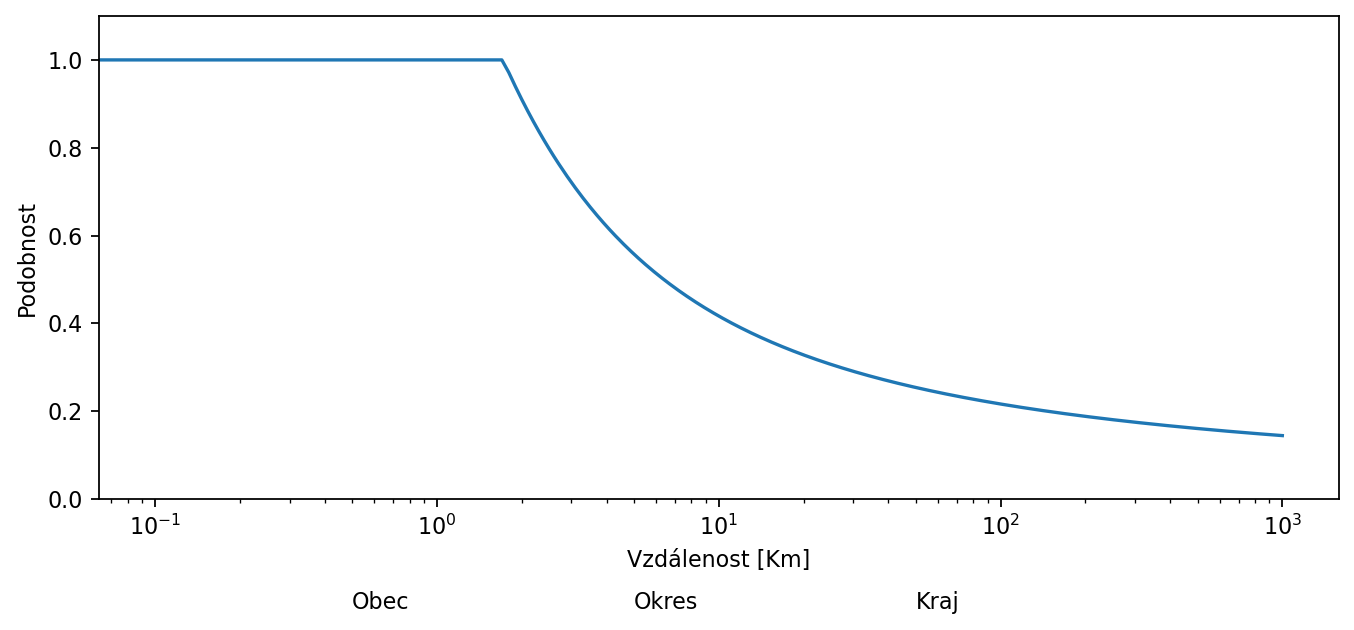

In [59]:
import numpy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

t = numpy.arange(0, 1000, 0.1)
sim = numpy.array(list(map(lambda x: min(1,1/numpy.log1p(x)), t)))

# plt.figure(num=None, figsize=(10, 4), dpi=160, facecolor='w', edgecolor='k')
fig, ax = plt.subplots(figsize=(10, 4),dpi=160)
ax.plot(t,sim)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(numpy.arange(start, end, 0.712123))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.ylabel('Podobnost')
plt.xlabel('Vzdálenost [Km]')
plt.ylim(0,1.1)
plt.xscale('log')
plt.text(0.5,-0.25,'Obec')
plt.text(5,-0.25,'Okres')
plt.text(50,-0.25,'Kraj')
plt.show()